In [1]:
# !pip install pandas
import pandas as pd
import os
import ast
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


In [ ]:
def process_string(input_string):
    reduced_spaces = re.sub(r'\s+', ' ', input_string)
    trimmed = re.sub(r'^[^\w.-]+', '', reduced_spaces)
    trimmed = re.sub(r'[^\w.-]+$', '', trimmed)
    result = re.sub(r' ', ',', trimmed)
    
    return result

def extract_pose_string(text):
    return ast.literal_eval(f"[{process_string(text)}]")


def draw_direction_annotation(position, yaw, ax, scale=0.4, is_grad=True, is_goal=False):
    x, y = position
    # Convert yaw from degrees to radians
    if not is_grad:
        yaw_rad = np.deg2rad(yaw)
    else:
        yaw_rad = yaw

    
    # Calculate the direction vector based on the yaw angle
    dx = np.cos(yaw_rad)
    dy = np.sin(yaw_rad)
    
    # Calculate the perpendicular direction vector
    perp_dx = -dy
    perp_dy = dx
    
    # Scale the perpendicular vector for the short line
    line_length = 0.2
    perp_dx *= line_length
    perp_dy *= line_length
    
    # Create the plot
    ax.plot(x, y, 'ro')  # Plot the position as a red dot
    
    # Add the annotation arrow
    ax.annotate('', xy=(x + dx*scale, y + dy*scale), xytext=(x, y),
                 arrowprops=dict(facecolor='green' if is_goal else 'blue', 
                                 shrink=0.05, 
                                 width=0.5, 
                                 headwidth=5))
    
    # Draw the short perpendicular line
    ax.plot([x - perp_dx, x + perp_dx], [y - perp_dy, y + perp_dy], 'g-')

In [11]:
file_dir = "./simdata/multi_pose/"

def get_df_from_lines(data, parameters):
    headers = data[0].split(",")
    data_dict = {}
    for line in data[1:]:
        line_info = line.split(",")
        for idx, header in enumerate(headers):
            if header not in data_dict:
                data_dict[header] = [float(line_info[idx])]
            else:
                data_dict[header].append(float(line_info[idx]))

    df = pd.DataFrame(data_dict)
    parameters_dict = {line.split(",")[0]: "".join(line.split(",")[1:]) for line in parameters}
    df["parameters"] = str(parameters_dict)
    df["N_kappa"] = ast.literal_eval(parameters_dict["N_kappa"]) 
    df["state_init"] = parameters_dict["state_init"]

    return df


df_list = []
for root, dirs, files in os.walk(file_dir):
    for fn in files:
        if not fn.endswith(".csv"):
            continue
        file_path = os.path.join(root, fn)

        with open(file_path) as f:
            data = f.read().splitlines()

        parameters = []
        for from_line, line in enumerate(data):
            if line.startswith("t [s]"):
                break

            parameters.append(line)
        df = get_df_from_lines(data[from_line:], parameters)
        df_list.append(df)

concat_df = pd.concat(df_list)

In [12]:
df_group_info = concat_df.groupby(['N_kappa', 'state_init']).size()
df_group_info

N_kappa       state_init                           
[0.5 9 -2.5]  [ 0.         -3.          1.57079633]    143
              [ 0.         -3.          3.14159265]    143
              [ 0.e+00 -3.e+00  1.e-03]                143
              [ 3.         -3.          1.57079633]    143
              [ 3.         -3.          3.14159265]    143
                                                      ... 
[1.5 9 -2.5]  [3.         0.         3.14159265]       143
              [3.         3.         1.57079633]       143
              [3.         3.         3.14159265]       143
              [3.e+00 0.e+00 1.e-03]                   143
              [3.e+00 3.e+00 1.e-03]                   143
Length: 96, dtype: int64

In [127]:
chosen_kappa = concat_df["N_kappa"].unique()[0]



In [ ]:
def plot_trajectories_given_kappa(chosen_kappa, image_path):
    sub_df_1 = concat_df[concat_df["N_kappa"] == chosen_kappa]
    pose_list = sub_df_1["state_init"].unique()

    inital_angle = np.array([extract_pose_string(p) for p in pose_list])
    inital_angles = list(set(inital_angle[:, 2]))

    fig, axes = plt.subplots(len(inital_angles), 1, sharey=True, figsize=(8, 20))
    for i_ax, inital_angle in enumerate(inital_angles):
        for pose in pose_list:
            pose_arr = extract_pose_string(pose)
            if pose_arr[2] != inital_angles[i_ax]:
                continue

            sub_df_2 = sub_df_1[sub_df_1["state_init"] == pose]
            line_style = 'b--' if sub_df_2["v [m/s]"].iloc[5] > 0 else 'r--'
            axes[i_ax].plot(sub_df_2["x [m]"], sub_df_2["y [m]"], line_style, lw=0.5)
            axes[i_ax].set_title("Kappa: {} - inital_angles: {}".format(
                                 chosen_kappa, inital_angles[i_ax]))

            # draw initial pose
            draw_direction_annotation(pose_arr[:2], pose_arr[2], axes[i_ax])

        # draw goal pose
        draw_direction_annotation([0, 0], 0, axes[i_ax], is_goal=True)
        red_patch = mpatches.Patch(color='red', label='Moving backward')
        blue_patch = mpatches.Patch(color='blue', label='Moving forward')
        axes[i_ax].legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1, 0.5))

        axes[i_ax].set_xlabel('X axis')
        axes[i_ax].set_ylabel('Y axis')
        
        # Show the plot
        axes[i_ax].grid(True)
        # Set plot limits for better visualization
        axes[i_ax].set_xlim(-3.5, 3.5)
        axes[i_ax].set_xlim(-3.5, 3.5)

    fig.savefig(image_path, dpi=fig.dpi)


[1.5, 9, -2.5]

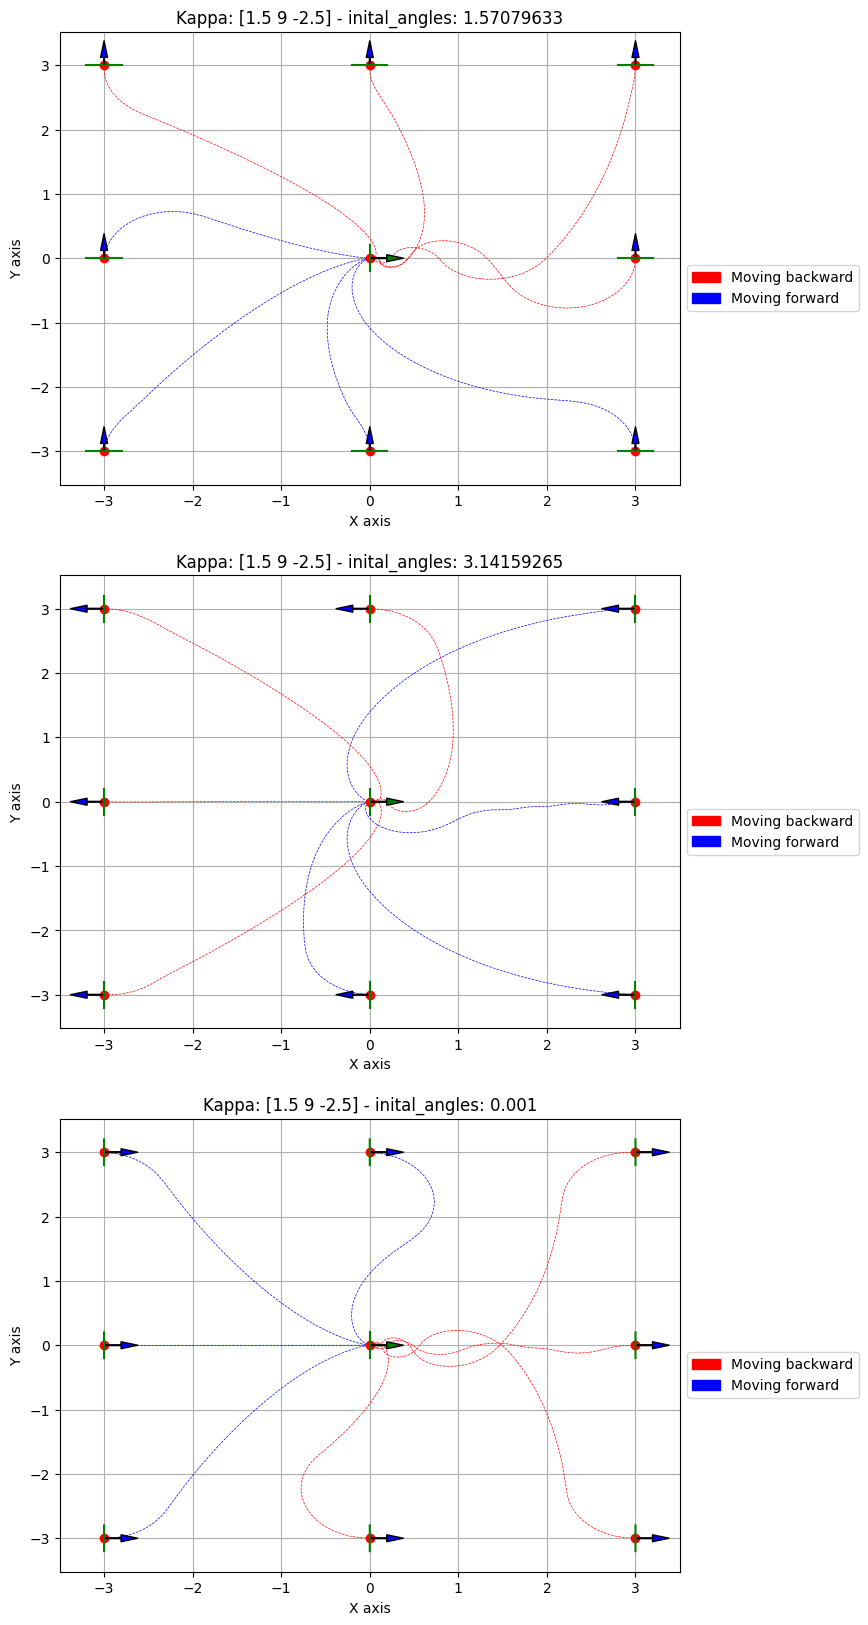

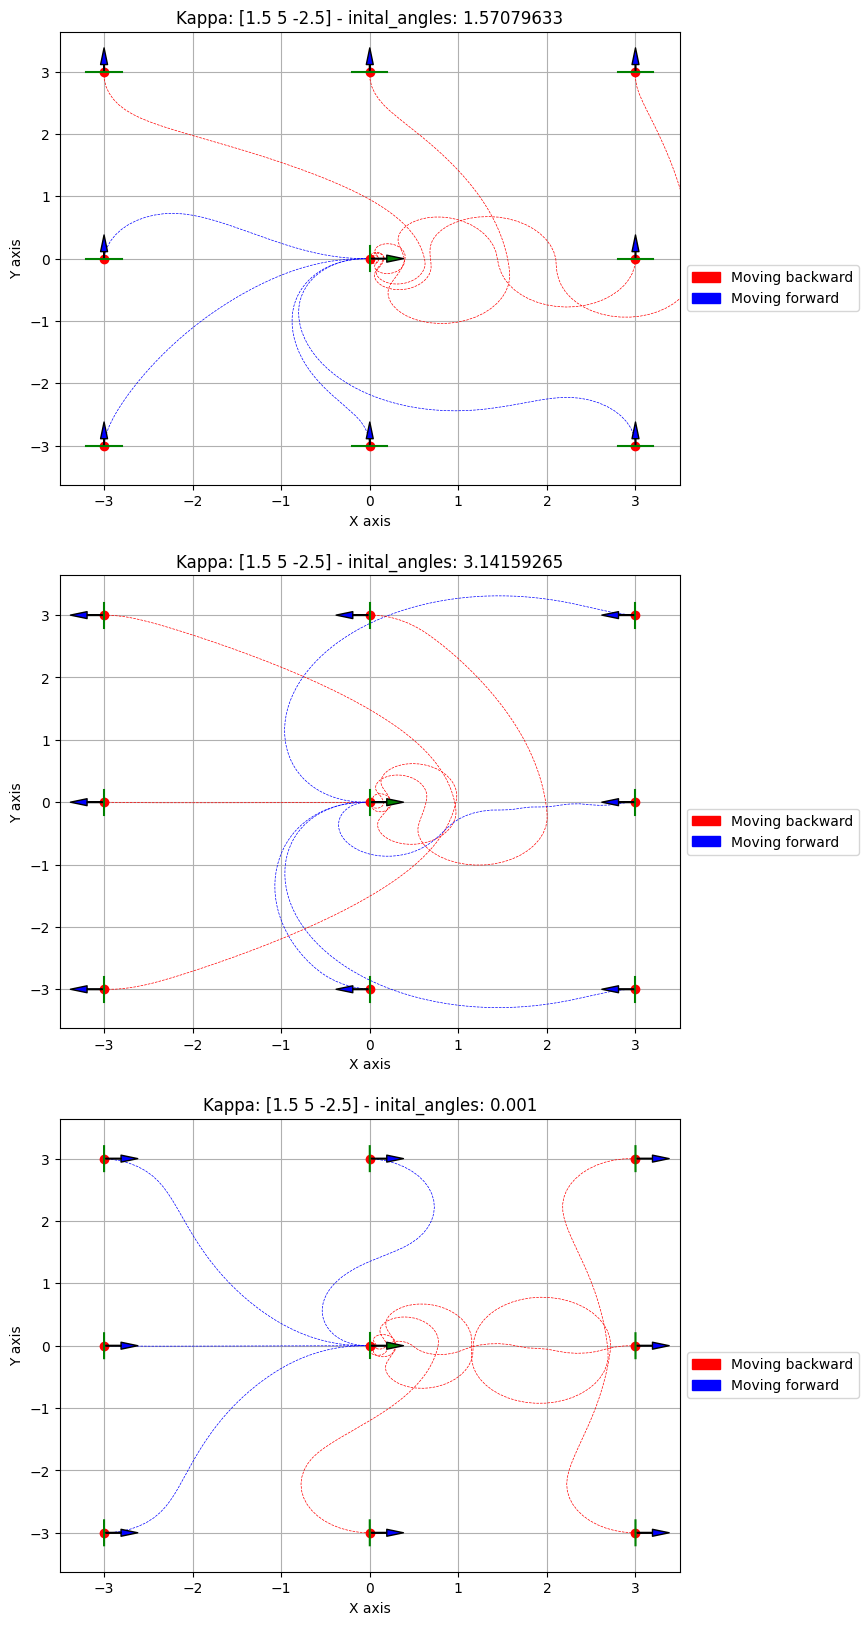

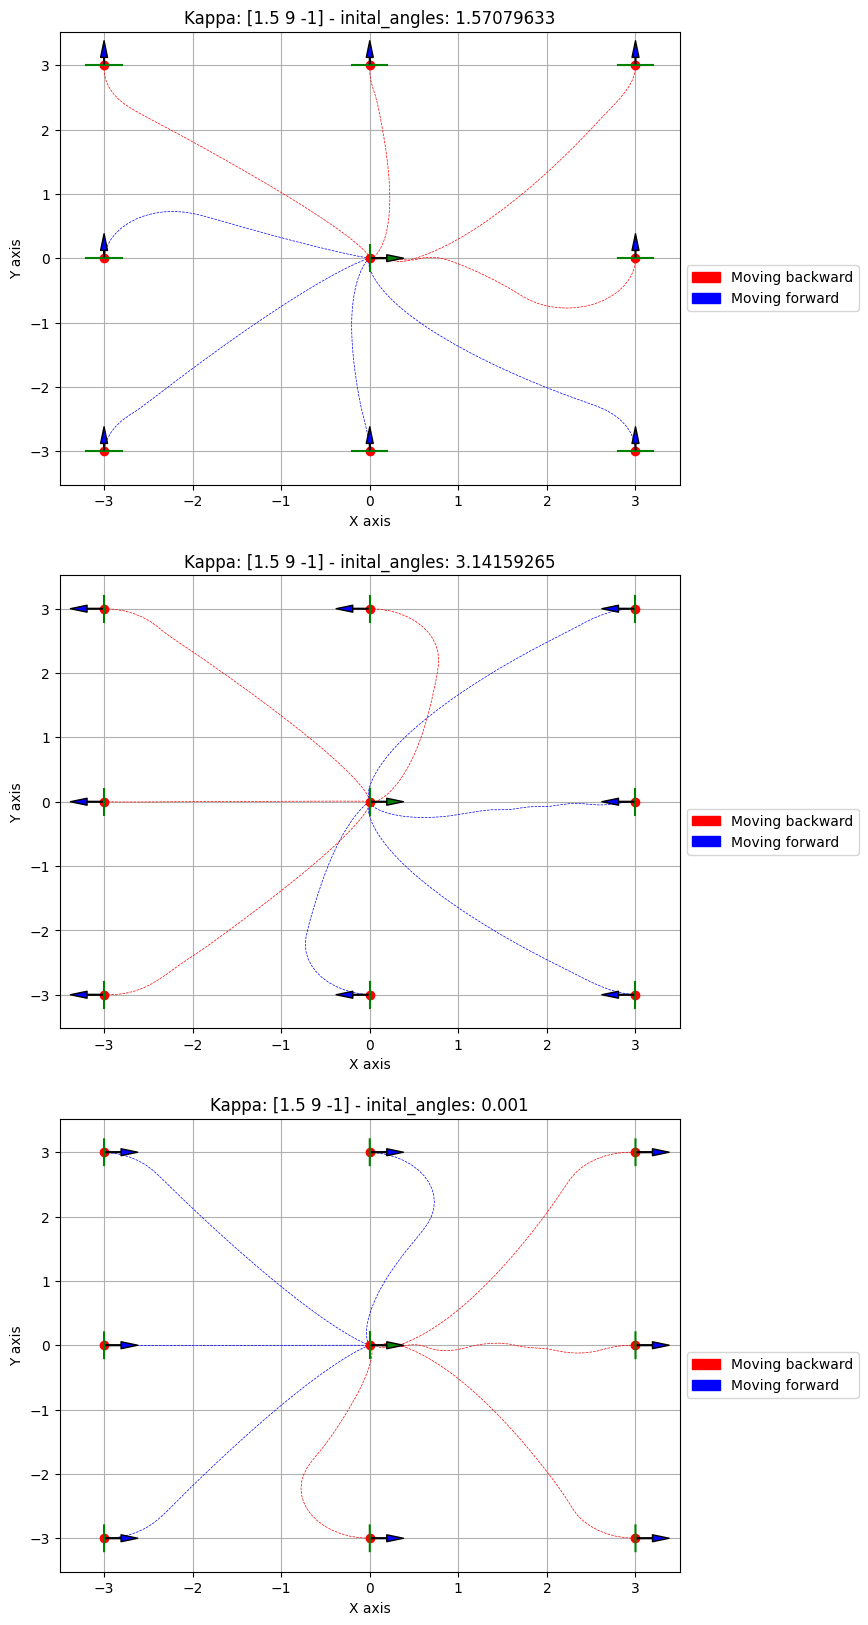

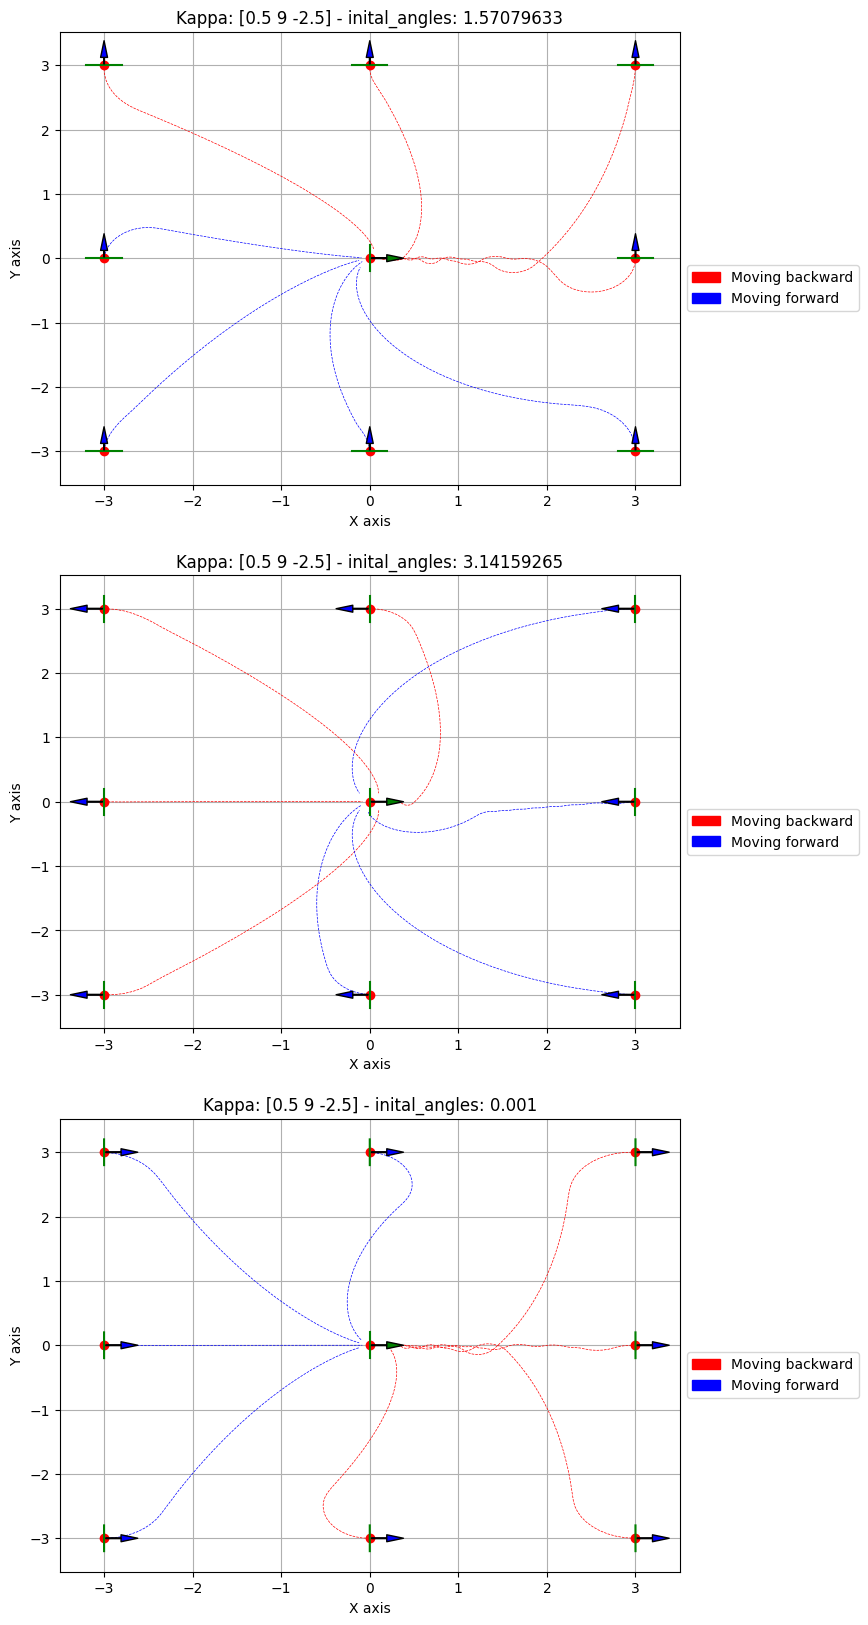

In [134]:
for chosen_kappa in concat_df["N_kappa"].unique():
    fn = "N_CTRL_kappa_{}_{}_{}_trajectories.svg".format(*extract_pose_string(concat_df["N_kappa"].unique()[0]))
    file_path = os.path.join("media", fn)
    plot_trajectories_given_kappa(chosen_kappa, image_path=file_path)

In [70]:
# sub_df_2.loc[sub_df_2["v [m/s]"] > 0] 
# sub_df_2["v [m/s]"]
sub_df_2["v [m/s]"].iloc[5]

-2.2

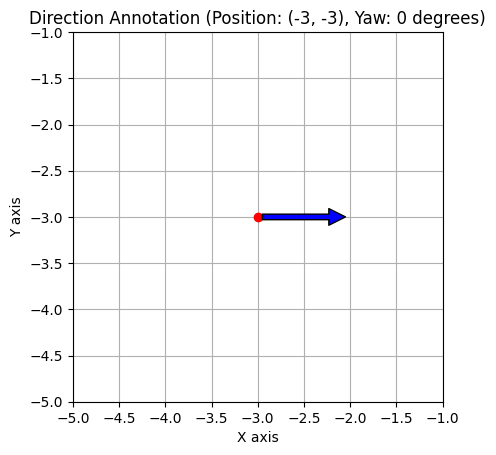

In [78]:


# Example usage
position = (-3, -3)
yaw = 0  # Degrees
draw_direction_annotation(position, yaw)

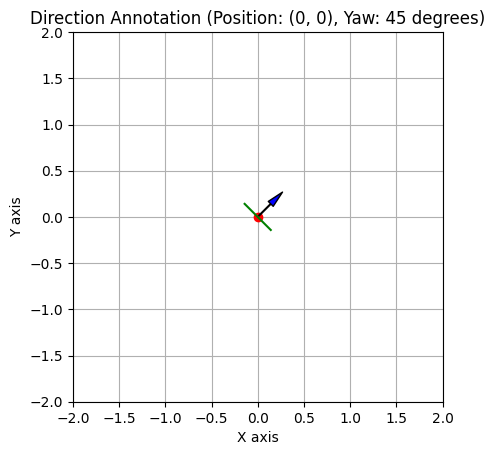

In [86]:
def draw_direction_annotation(position, yaw, scale=0.4):
    x, y = position
    # Convert yaw from degrees to radians
    yaw_rad = np.deg2rad(yaw)
    
    # Calculate the direction vector based on the yaw angle
    dx = np.cos(yaw_rad)
    dy = np.sin(yaw_rad)
    
    # Calculate the perpendicular direction vector
    perp_dx = -dy
    perp_dy = dx
    
    # Scale the perpendicular vector for the short line
    line_length = 0.2
    perp_dx *= line_length
    perp_dy *= line_length
    
    # Create the plot
    plt.figure()
    plt.plot(x, y, 'ro')  # Plot the position as a red dot
    
    # Add the annotation arrow
    plt.annotate('', xy=(x + dx*scale, y + dy*scale), xytext=(x, y),
                 arrowprops=dict(facecolor='blue', shrink=0.05, width=0.5, headwidth=5))
    
    # Draw the short perpendicular line
    plt.plot([x - perp_dx, x + perp_dx], [y - perp_dy, y + perp_dy], 'g-')
    
    # Set plot limits for better visualization
    plt.xlim(x - 2, x + 2)
    plt.ylim(y - 2, y + 2)
    
    # Add labels and title


# Example usage
position = (0, 0)
yaw = 45  # Degrees
draw_direction_annotation(position, yaw)

<Axes: title={'center': 'runned trajectory'}, xlabel='x [m]'>

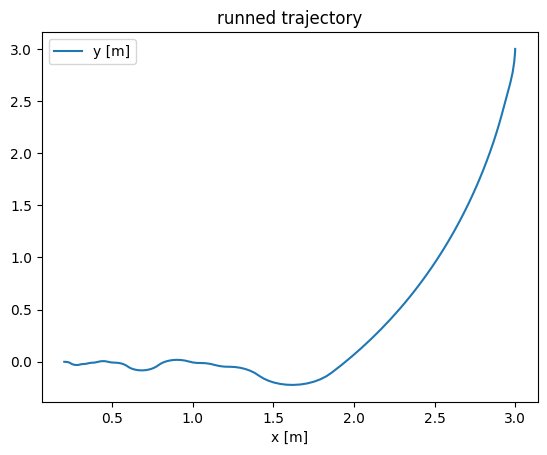

In [9]:
# df.drop(columns=["t [s]", "stage_obj", "accum_obj"]).plot()
df = df[df["t [s]"] > 0.0005]
df.plot(x="x [m]", y="y [m]", title="runned trajectory")

<Axes: title={'center': 'runned trajectory'}, xlabel='t [s]'>

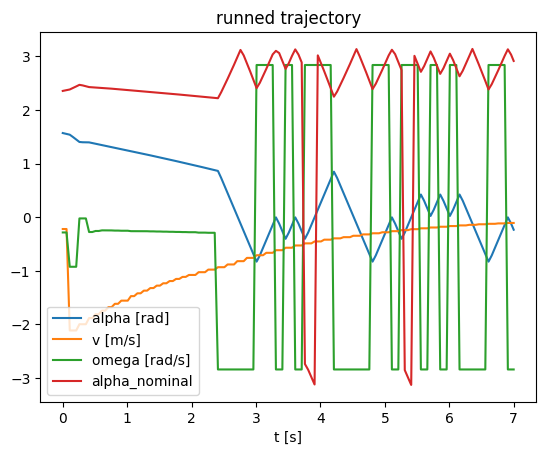

In [10]:
import numpy as np

df["alpha_nominal"] = df.apply(lambda row:-row["alpha [rad]"] + np.arctan2(-row["y [m]"], -row["x [m]"]), axis=1)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi - value if value > np.pi else value)
df["alpha_nominal"] = df["alpha_nominal"].apply(lambda value: 2*np.pi + value if value < -np.pi else value)
# df.plot(x="t [s]", y="alpha", title="runned trajectory")
df.plot(x="t [s]", y=["alpha [rad]", "v [m/s]", "omega [rad/s]", "alpha_nominal"], title="runned trajectory")

In [11]:
k_a = 20
k_b = -0.05

df["beta"] = df.apply(lambda row:-row["alpha [rad]"] - row["alpha_nominal"], axis=1)
df["re-cal-omega"] = df["alpha_nominal"] * k_a + df["beta"] * k_b
print(df.to_markdown())

|     |     t [s] |    x [m] |       y [m] |   alpha [rad] |    run_obj |   accum_obj |   v [m/s] |   omega [rad/s] |   alpha_nominal |     beta |   re-cal-omega |
|----:|----------:|---------:|------------:|--------------:|-----------:|------------:|----------:|----------------:|----------------:|---------:|---------------:|
|   1 | 0.0011    | 3        |  2.9998     |    1.57054    | 1824.55    |     364.922 | -0.22     |      -0.284     |         2.35642 | -3.92696 |        47.3247 |
|   2 | 0.0096257 | 3        |  2.99792    |    1.56812    | 1823.34    |     547.256 | -0.22     |      -0.284     |         2.35853 | -3.92665 |        47.3669 |
|   3 | 0.0596257 | 2.99989  |  2.98693    |    1.55392    | 1816.25    |     728.882 | -0.22     |      -0.284     |         2.37091 | -3.92483 |        47.6144 |
|   4 | 0.109626  | 2.99963  |  2.97593    |    1.53972    | 1809.1     |     909.791 | -2.11269  |      -0.92416   |         2.38331 | -3.92303 |        47.8623 |
|   5 | 0.159626

In [12]:
df
df.plot(x="t [s]", y=["stage_obj"], title="object")
df.plot(x="t [s]", y=["x [m]", "y [m]"], title="object")

KeyError: "None of [Index(['stage_obj'], dtype='object')] are in the [columns]"

In [ ]:
np.arctan2(-1.995, -1.763), np.arctan2(1.995, 1.763)

(-2.294537774150904, 0.8470548794388896)

In [ ]:
import numpy as np

initial_position = np.array(np.meshgrid([-3, 0, 3], [-3, 0, 3])).T.reshape(-1, 2) 

array([-3,  0,  3, -3,  0,  3, -3,  0,  3])

In [ ]:
initial_position

array([[-3, -3],
       [-3,  0],
       [-3,  3],
       [ 0, -3],
       [ 0,  0],
       [ 0,  3],
       [ 3, -3],
       [ 3,  0],
       [ 3,  3]])